In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import pandas as pd
import struct
import numpy as np

In [3]:
dataset_train = pd.read_csv("fashion_dataset/fashion-mnist_train.csv")
dataset_test = pd.read_csv("fashion_dataset/fashion-mnist_test.csv")
dataset_train.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [4]:
def load_images(path):
    with open(path,'rb') as f:
        magic,num,rows,cols=struct.unpack(">IIII",f.read(16))
        images = np.frombuffer(f.read(),dtype=np.uint8).reshape(num,1,rows,cols)
        return torch.tensor(images,dtype=torch.float32)/255.0

images_tensor=load_images("fashion_dataset/train-images-idx3-ubyte")
print(images_tensor.shape)

torch.Size([60000, 1, 28, 28])


In [5]:
def load_labels(path):
    with open(path,'rb') as f:
        magic,num_labels=struct.unpack(">II",f.read(8))
        assert magic == 2049,f"Invalid magic number {magic}"
        label_bytes = f.read()
        labels = torch.tensor(list(label_bytes),dtype=torch.uint8)
        return labels

label_tensor = load_labels("fashion_dataset/train-labels-idx1-ubyte")
label_array = label_tensor.numpy()
label_arrayn=label_array.astype(np.int32)
label_arrayn

array([9, 0, 0, ..., 3, 0, 5])

In [6]:
LABELS = []

In [7]:
label_map = {
    0: "T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

In [8]:
len(label_array)

60000

In [9]:
for i in range(len(label_array)):
    LABELS.append(label_map[int(label_array[i])])

In [10]:
LABELS[:5]

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top']

Text(0.5, 1.0, 'Ankle boot')

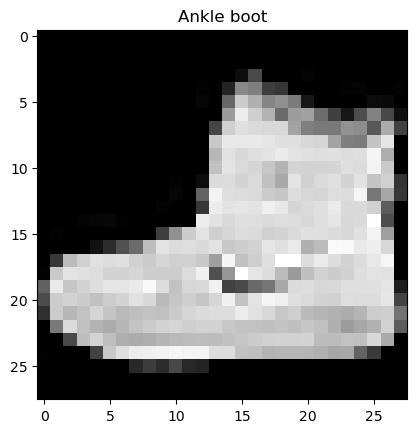

In [11]:

plt.imshow(images_tensor[0].squeeze(),cmap="gray")
plt.title(f"{LABELS[0]}")

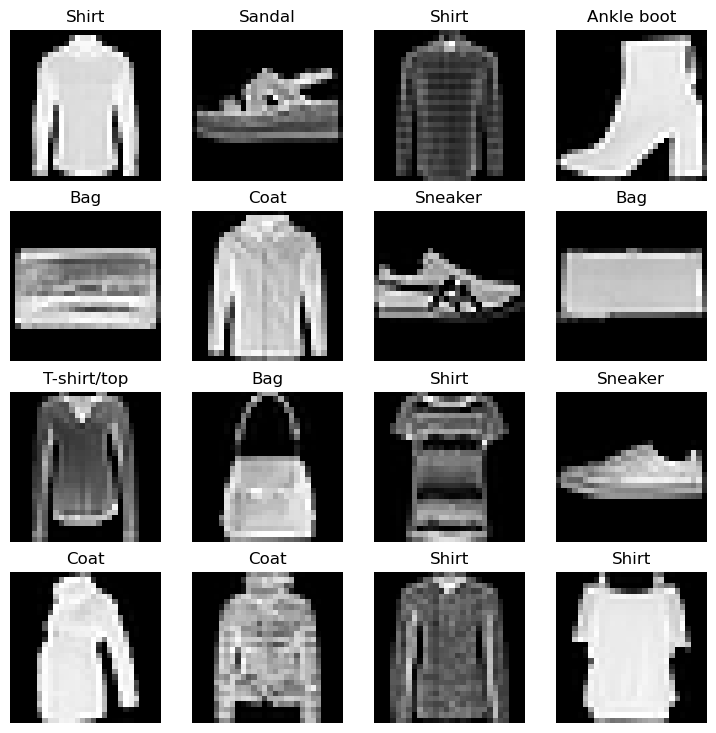

In [12]:
fig = plt.figure(figsize=(9,9))
rows,cols=4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(images_tensor),size=[1]).item()
    img = images_tensor[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(LABELS[random_idx])
    plt.axis(False)

In [13]:
len(images_tensor),images_tensor.shape

(60000, torch.Size([60000, 1, 28, 28]))

In [14]:
train_num = int(len(images_tensor)*0.8)

train_dataset,test_dataset = images_tensor[:train_num],images_tensor[train_num:]
train_labels,test_labels = label_arrayn[:train_num],label_arrayn[train_num:]
len(test_dataset),len(train_dataset),len(train_labels)

(12000, 48000, 48000)

### Prepare Dataloader 

In [16]:
BATCH_SIZE = 32

from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset from images and labels
train_data = TensorDataset(train_dataset, torch.tensor(train_labels, dtype=torch.long))
test_data = TensorDataset(test_dataset, torch.tensor(test_labels, dtype=torch.long))


# create the DataLoaders
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader),len(test_dataloader)

(1500, 375)

In [17]:
train_features_batch= next(iter(train_dataloader))   

### Building a Model

In [19]:
class fashionClassificationModel(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        ).to("cpu")

    def forward(self,x):
        return self.layer_stack(x)
             
                 

In [20]:
torch.manual_seed(42)
model = fashionClassificationModel(input_shape=784,hidden_units=10,output_shape=10)

In [21]:
dummy_x = torch.rand([1,1,28,28])
print(model(dummy_x))

tensor([[0.0806, 0.1593, 0.1565, 0.0000, 0.4741, 0.1441, 0.1634, 0.3834, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [23]:
train_dataloader.dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

In [24]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    train_loss = 0

    for batch,(X,y) in enumerate(train_dataloader):
        model.train()

        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
        train_loss /= len(train_dataloader)

    #Testing Loop
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_pred = model(X_test)
            test_loss +=  loss_fn(test_pred,y_test)
        test_loss /= len(test_dataloader)

    
    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} ")
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/48000 samples.
Looked at 12800/48000 samples.
Looked at 25600/48000 samples.
Looked at 38400/48000 samples.

Train Loss: 0.0008 | Test Loss: 1.1977 
Epoch: 1
------
Looked at 0/48000 samples.
Looked at 12800/48000 samples.
Looked at 25600/48000 samples.
Looked at 38400/48000 samples.

Train Loss: 0.0004 | Test Loss: 0.7096 
Epoch: 2
------
Looked at 0/48000 samples.
Looked at 12800/48000 samples.
Looked at 25600/48000 samples.
Looked at 38400/48000 samples.

Train Loss: 0.0004 | Test Loss: 0.6641 
